In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [26]:
import os
os.chdir('/content/drive/MyDrive/CV5/utils')

In [27]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

from PIL.ExifTags import TAGS
from engine import train_one_epoch, evaluate
import utils
from torchvision import transforms as T  

In [28]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Projects/Gun_Detection/gun_detection.csv')
df.image_path[119]

'armas--120--jpg_jpg.rf.e2a1ab7d314992a5e284980022371fde.jpg'

In [29]:
class DataSet(torch.utils.data.Dataset):
    
    def __init__(self,root, data_file, transform):
        self.root = root ### mapa cu fotografii
        self.transform = transform
        self.data = pd.read_csv(data_file, sep=',')
        self.imgs = self.data['image_path'].values
        self.path_to_data_file = data_file
        
    def __getitem__(self,idx):
        
        img_path = os.path.join(self.root,self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        
        for orientation in TAGS.keys() : 
            if TAGS[orientation]=='Orientation' : break 
        # Getting the exif
        exif=dict(img.getexif().items())
        # Rotating the image if the orientation is wrong.
        if len(exif)!=0:                                                             
            if orientation in exif.keys():
                if exif[orientation] == 3 : 
                    img=img.rotate(180, expand=True)
                elif exif[orientation] == 6 : 
                    img=img.rotate(270, expand=True)
                elif exif[orientation] == 8 : 
                    img=img.rotate(90, expand=True)
                    
        box_list = self.data[self.data['image_path']==self.imgs[idx]][['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_obj = len(box_list)
        labels = torch.ones((num_obj,), dtype = torch.int64)
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])
        
        image_id = torch.tensor([idx])
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = image_id
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return len(self.data)

In [30]:
transformations = T.Compose([T.ToTensor()])

dataset = DataSet('/content/drive/MyDrive/Colab_Projects/Gun_Detection/data', 
                  '/content/drive/MyDrive/Colab_Projects/Gun_Detection/gun_detection.csv', 
                  transformations)

torch.manual_seed(1)

indices = torch.randperm(len(dataset)).tolist()
train = torch.utils.data.Subset(dataset, indices[:100])
test = torch.utils.data.Subset(dataset, indices[100:])

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True, collate_fn = utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False, collate_fn = utils.collate_fn)

In [31]:
def get_model(num_clase):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    for param in model.parameters():
        param.required_grad = False
        
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_clase)
    
    return model

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

num_clase = 2
model = get_model(num_clase).to(DEVICE)

params  = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

In [33]:
num_epoch = 5

for epoch in range(num_epoch):
    
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, print_freq = 10)
    
    evaluate(model, test_loader, device=DEVICE)

Epoch: [0]  [  0/100]  eta: 0:01:06  lr: 0.000055  loss: 0.9021 (0.9021)  loss_classifier: 0.7394 (0.7394)  loss_box_reg: 0.1395 (0.1395)  loss_objectness: 0.0145 (0.0145)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 0.6631  data: 0.0153  max mem: 1413
Epoch: [0]  [ 10/100]  eta: 0:01:08  lr: 0.000560  loss: 0.6055 (0.5969)  loss_classifier: 0.4539 (0.4487)  loss_box_reg: 0.1192 (0.1272)  loss_objectness: 0.0130 (0.0149)  loss_rpn_box_reg: 0.0067 (0.0060)  time: 0.7643  data: 0.1659  max mem: 1679
Epoch: [0]  [ 20/100]  eta: 0:01:02  lr: 0.001065  loss: 0.3805 (0.4841)  loss_classifier: 0.2145 (0.3292)  loss_box_reg: 0.1127 (0.1286)  loss_objectness: 0.0074 (0.0193)  loss_rpn_box_reg: 0.0060 (0.0071)  time: 0.7807  data: 0.1880  max mem: 1679
Epoch: [0]  [ 30/100]  eta: 0:00:55  lr: 0.001569  loss: 0.3376 (0.4383)  loss_classifier: 0.1838 (0.2765)  loss_box_reg: 0.1351 (0.1388)  loss_objectness: 0.0094 (0.0169)  loss_rpn_box_reg: 0.0048 (0.0062)  time: 0.8124  data: 0.2221  max mem: 1679


In [34]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab_Projects/Gun_Detection/gun_detection_model.pth')

In [35]:
loaded_model = get_model(num_clase=2)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Projects/Gun_Detection/gun_detection_model.pth'))

<All keys matched successfully>

Prediction with score above 0.3


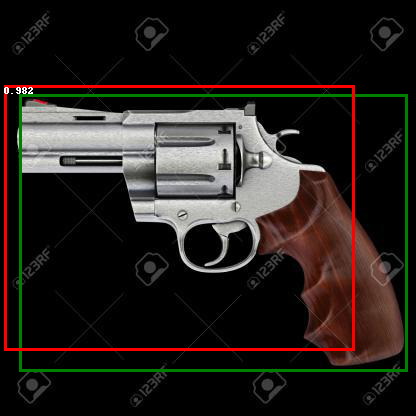

Prediction with score above 0.3


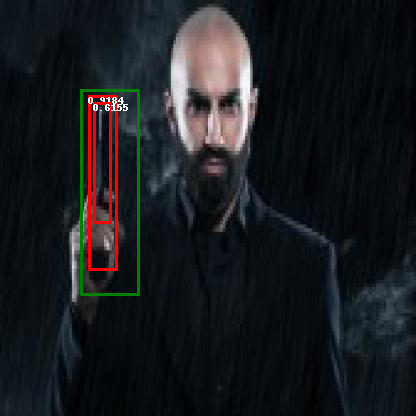

Prediction with score above 0.3


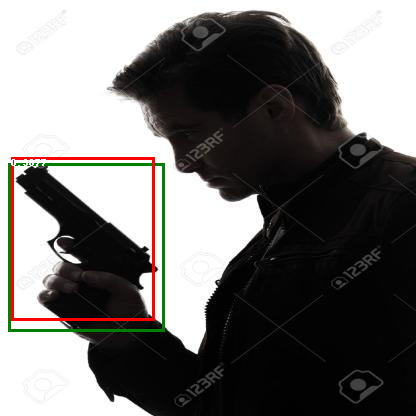

Prediction with score above 0.3


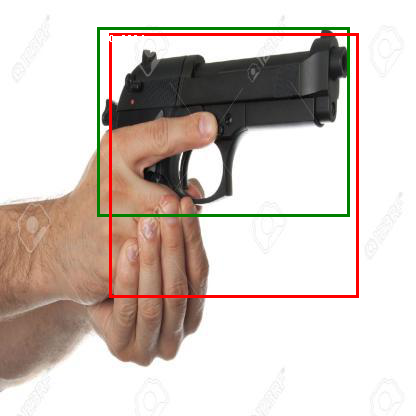

Prediction with score above 0.3


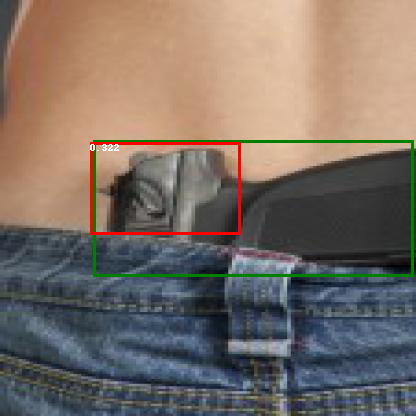

Prediction with score above 0.3


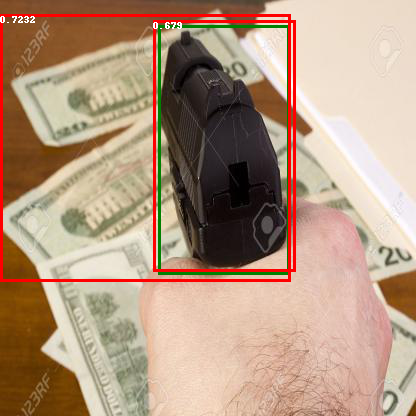

Prediction with score above 0.3


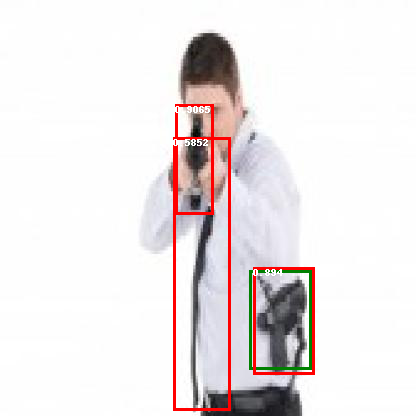

Prediction with score above 0.3


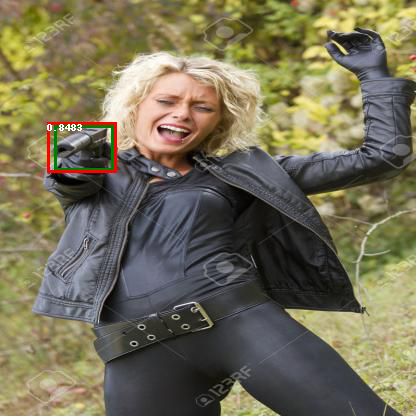

Prediction with score above 0.3


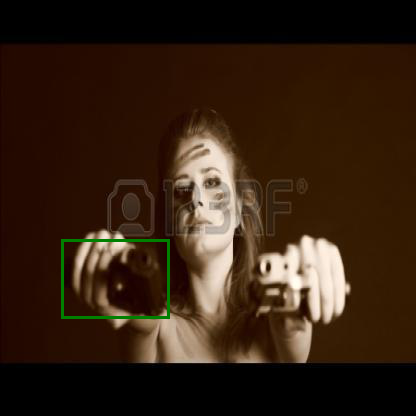

Prediction with score above 0.3


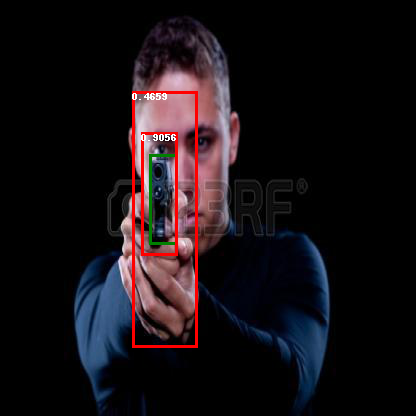

Prediction with score above 0.3


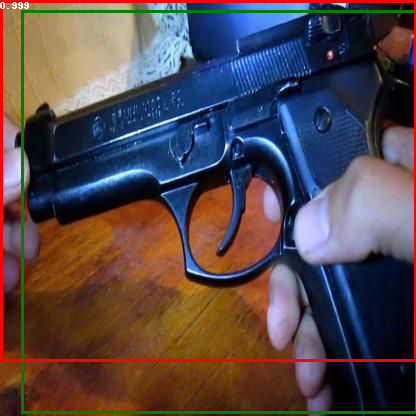

Prediction with score above 0.3


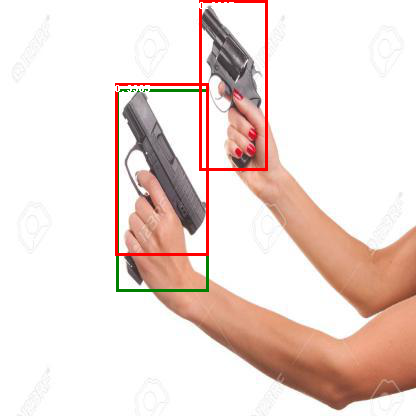

Prediction with score above 0.3


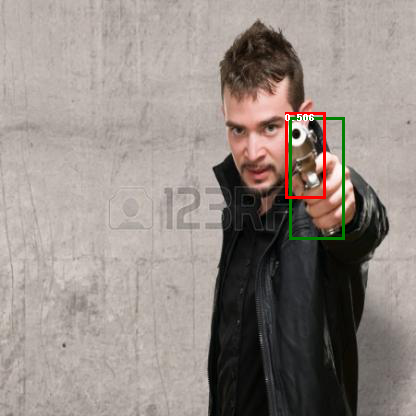

Prediction with score above 0.3


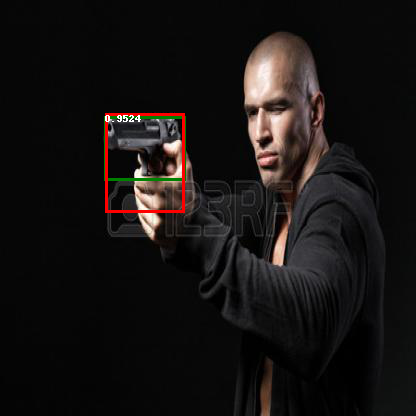

Prediction with score above 0.3


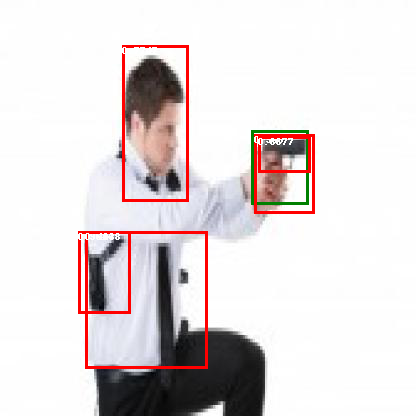

Prediction with score above 0.3


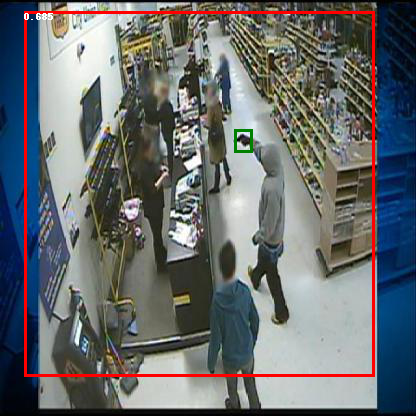

Prediction with score above 0.3


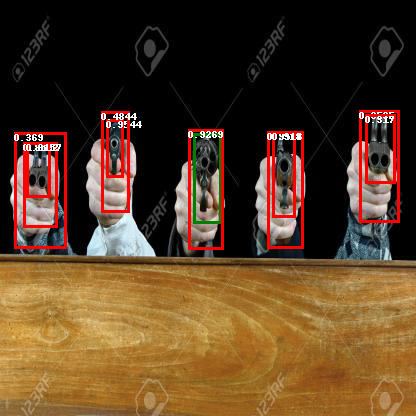

Prediction with score above 0.3


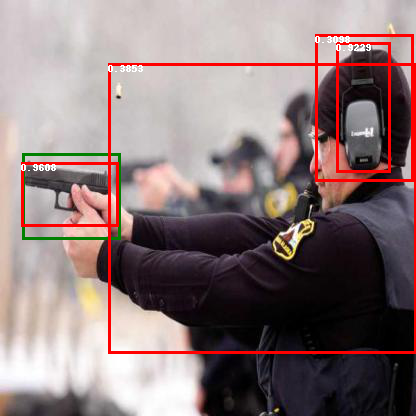

In [39]:
# Use this code to made a predition.
from PIL import ImageDraw
# Getting the image.
for idx in range(2,20):
    img, _ = test[idx]
    # Getting the object coordinates.
    label_boxes = np.array(test[idx][1]['boxes'])

    # Setting the model to eval state.
    loaded_model.eval()
    # Making the prediction.
    with torch.no_grad():
        prediction = loaded_model([img])

    # Getting an drawing the image.
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)

    # Drawing the real box around the object.
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                       (label_boxes[elem][2], label_boxes[elem][3])],
                      outline='green', width=3)
    # Drawing the predicted box around the object.
    print("Prediction with score above 0.3")
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()                                     
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=4)

        if score > 0.3:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                         outline='red', width=3)
            draw.text((boxes[0], boxes[1]), text=str(score))
    display(image)